<center><span style="font-size:30px;"><b>PLANT PATHOLOGY USING TRANSFER LEARNING (ResNet50)</span>

<span style="font-size:28px;">TABLE OF CONTENTS:
    
------------------------------------------------------------------------------------------------------    
    
* <span style="font-size:26px;">Import Required Libraries
* <span style="font-size:26px;">Load the Images (Train_images), DataFrame (train.csv)
* <span style="font-size:26px;">Data Augumentation using ImageDataGenerator
* <span style="font-size:26px;">Create Model (ResNet50)
* <span style="font-size:26px;">Create Callbacks
* <span style="font-size:26px;">Fit the model
* <span style="font-size:26px;">Test the Model
* <span style="font-size:26px;">Make the Submission
    

-------------

## 1. IMPORT LIBRARIES

In [42]:
#IMPORT REQUIRED LIBRARIES:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

## 2. DATASET LOCATION

In [2]:
TRAIN_PATH = "../input/plant-pathology-2021-fgvc8/train_images"
train_df = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")

In [4]:
count_dict = train_df.labels.value_counts()
classes = list(count_dict.index)
classes_count = list(count_dict.values)
print("Number of unique labels: ",len(classes))
print("-------------------------------------------")
train_df.head()

Number of unique labels:  12
-------------------------------------------


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


-----

## 3. VISUALIZATION

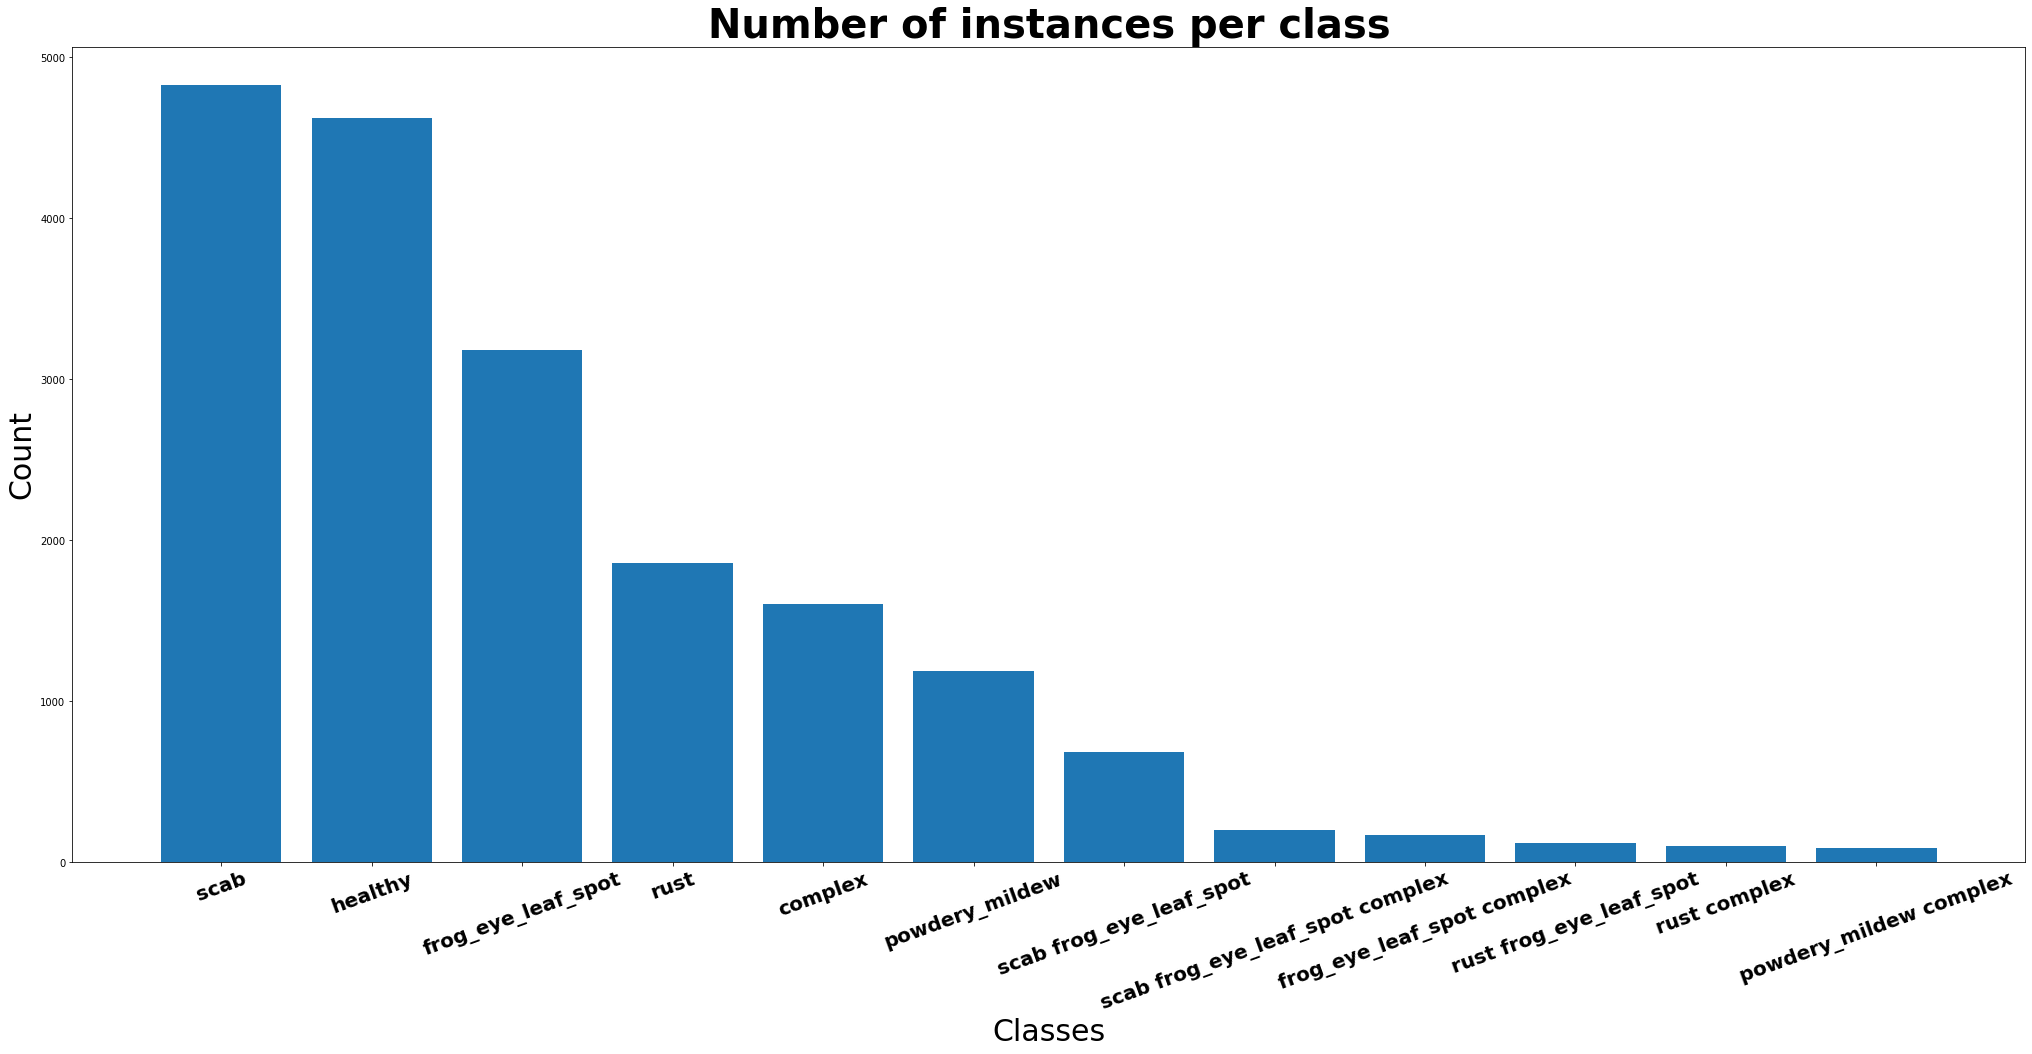

In [5]:
plt.figure(figsize=(35,15))
plt.bar(classes,classes_count)
plt.title("Number of instances per class",fontweight="bold",fontsize=40)
plt.xlabel("Classes",fontsize = 30)
plt.xticks(rotation=20,fontsize = 20,fontweight = "bold")
plt.xticks(fontsize = 20,fontweight = "bold")
plt.ylabel("Count",fontsize=30)
plt.show()

-----

## 4. DATA AUGMENTATION

In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)



In [15]:
HEIGHT = 124
WIDTH=124
SEED = 143
BATCH_SIZE=32
train_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 14906 non-validated image filenames belonging to 12 classes.


In [17]:
val_ds = train_datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 3726 non-validated image filenames belonging to 12 classes.


-----

## 5. CREATE THE RESNET MODEL

In [25]:
import tensorflow
def create_model():
    
    pretrained = ResNet50(include_top=False, weights='imagenet',input_shape=[HEIGHT,WIDTH, 3])
            
    x = pretrained.output
    x = tensorflow.keras.layers.GlobalAveragePooling2D() (x)
    outputs = tensorflow.keras.layers.Dense(len(classes),activation="softmax", dtype='float32')(x)
        
    model = tensorflow.keras.Model(pretrained.input, outputs)
    return model

model = create_model()

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 124, 124, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 130, 130, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 62, 62, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 62, 62, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

-----

## 6. COMPILE THE MODEL

In [27]:
import tensorflow_addons as tfa

def compile_model(model, lr=0.0001):
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    
    loss = tensorflow.keras.losses.CategoricalCrossentropy()
    
    #tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    metrics = [
    tfa.metrics.F1Score(num_classes = len(classes),average = "macro",name = "f1_score")
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

------

## 7. CREATE CALLBACKS

In [28]:
METRIC = "val_f1_score"

def create_callbacks(metric = METRIC):
    
    cpk_path = './best_model.h5'
    
    checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tensorflow.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tensorflow.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

-------

## 8. FIT THE MODEL

In [30]:
EPOCHS= 3
VERBOSE =1

tensorflow.keras.backend.clear_session()

with tensorflow.device('/device:GPU:0'):
    
    model = create_model()
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks()
    
    history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE
                       )

Epoch 1/3
466/466 [==============================] - 3018s 6s/step - loss: 1.3856 - f1_score: 0.2816 - val_loss: 25.6052 - val_f1_score: 0.0299

Epoch 00001: val_f1_score improved from -inf to 0.02988, saving model to ./best_model.h5
Epoch 2/3
466/466 [==============================] - 2908s 6s/step - loss: 0.7004 - f1_score: 0.4392 - val_loss: 3.2317 - val_f1_score: 0.1585

Epoch 00002: val_f1_score improved from 0.02988 to 0.15848, saving model to ./best_model.h5
Epoch 3/3
466/466 [==============================] - 2833s 6s/step - loss: 0.5725 - f1_score: 0.5035 - val_loss: 0.5779 - val_f1_score: 0.4562

Epoch 00003: val_f1_score improved from 0.15848 to 0.45619, saving model to ./best_model.h5


------

## 9. SUBMISSION OF FILE

In [31]:
submission = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv')
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [34]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)
INPUT_SIZE = (124,124,3)
test_generator =  test_datagen.flow_from_dataframe(
    submission,
    directory="../input/plant-pathology-2021-fgvc8/test_images",
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)

Found 3 validated image filenames.


In [35]:
train_ds.class_indices.items()

dict_items([('complex', 0), ('frog_eye_leaf_spot', 1), ('frog_eye_leaf_spot complex', 2), ('healthy', 3), ('powdery_mildew', 4), ('powdery_mildew complex', 5), ('rust', 6), ('rust complex', 7), ('rust frog_eye_leaf_spot', 8), ('scab', 9), ('scab frog_eye_leaf_spot', 10), ('scab frog_eye_leaf_spot complex', 11)])

In [36]:
def get_key(val):
    for key, value in train_ds.class_indices.items():
        if val == value:
            return key

In [37]:
preds = model.predict(test_generator)
print(preds)

[[5.5985365e-02 8.2338939e-04 1.2087198e-04 5.0248899e-03 1.0999626e-05
  1.0826892e-05 8.6495751e-01 6.8762020e-05 3.0563390e-03 6.7039989e-02
  2.6750055e-03 2.2593014e-04]
 [8.6697876e-01 2.1798855e-02 1.9506700e-02 7.0113083e-04 1.1216671e-04
  3.9624586e-04 1.1927149e-03 1.4824478e-03 1.7870951e-02 3.2233368e-03
  4.4081748e-02 2.2654885e-02]
 [2.3632612e-02 8.9363348e-01 6.2156171e-03 1.9191358e-04 3.5705554e-05
  5.6861114e-05 6.4246533e-03 4.2858828e-04 1.0051761e-02 2.7362813e-04
  5.7120413e-02 1.9347763e-03]]


In [38]:
def get_preds_to_labels(preds):
    pred_lists = []
    for pred in preds:
        pred_list = []
        health = (pred>=0.4)
        
        # get healthy
        if health.sum()==0:
            label = 'healthy'
            pred_list.append(label)
            
        elif pred[2]>=0.5:
            label = 'healthy'
            pred_list.append(label)
            
        # get eles label
        else:
            for j, sub in enumerate(pred):
                if sub>=0.28:
                    label = get_key(j)
                    pred_list.append(label)
                               
        pred_lists.append(' '.join(pred_list))
    return pred_lists

In [39]:
preds_list = get_preds_to_labels(preds)

In [40]:
submission['labels'] = preds_list
submission.head()

,image,labels
0,85f8cb619c66b863.jpg,rust
1,ad8770db05586b59.jpg,complex
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot


In [41]:
submission.to_csv('submission.csv', index=False)